In [2]:
import numpy as np
import pandas as pd
import pickle
from scipy.signal import savgol_filter as savgol
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF',\
         '#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'font.size':14});
plt.rc('lines',linewidth=2);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

from read_PR_data import PR_2_dicts # PR: plate reader 

In [3]:
def get_data(fn,nR,nC,sampling_rate):
    '''
    fn: string of the filename from plate reader. It is a text file that the BioTek instruments output 
    The function PR_2_dicts has code to scrape the file and outputs dictionaries with the well IDs as keys
    (Another tip since the code isn't perfect. Read OD first on the reader, then any fluorescence measurements)
    nR: number of rows (best to have the plate reader sample all rows and columns, because PR_2_dicts will 
    consider the first sampled well as A1, the second as A2 row wise.)
    nC: number of columns
    sampling_rate: The sampling time in minutes 
    '''
    data,numReads = PR_2_dicts(fn,nR,nC) 
    tspan = np.linspace(0,numReads*sampling_rate,numReads)/60 # time in hours
    for ii,measurements in enumerate(data): # will need to adjust this loop for new protocols
        if ii == 0: 
            od = measurements
        elif ii == 1: 
            afu1 = measurements
        elif ii == 2: 
            afu2 = measurements
            
    afu_normed = {}
    for key in afu1: 
        afu_normed[key] = afu1[key]/od[key]
        
    return od,afu1,afu_normed,tspan

def gen_well_keys(nR,nC):
    # generate list of well keys for treatment and control and corresponding tags
    import string
    row_keys = list(string.ascii_uppercase[0:nR])
    col_keys = range(1,nC+1)

    from itertools import product
    cartprod = list(product(row_keys,col_keys))

    well_keys = []
    for i in cartprod:
        well_keys.append(str(i[0]+str(i[1])))
        
    return well_keys

def plot_data(X,tspan,labels,conds,nR,nC,figsize,ic=0,addLegend=False,bboxanchor=(1.125,0.75),
              addLabels=False,xLabel='X',yLabel='Y',xPos=[0.5,-0.5],yPos=[-0.5,0.5],
              savefig=False,savedir='/Users/aqib/Desktop/fig.pdf'): 
    '''
    X: dictionary of data with keys as well locations
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    nR: number of rows for subplots
    nC: number of columns of subplots
    '''

    fig,axs = plt.subplots(nR,nC,figsize=figsize,sharex=True,sharey='row')
    for ii,ax in enumerate(axs.reshape(-1)):
        if ii < len(labels): # this is necessary because we have to generate a full grid of subplots
            strain = list(labels.keys())[ii] # formerly key
            ax.set_title(strain)
            for jj in range(len(conds)): # number of conditions per strain
                ax.plot(tspan[ic:],savgol(X[labels[strain][jj]][ic:],25,1,axis=0)) # data is smoothed while plotting
            for side in ax.spines.keys(): # top, bottom, left, right
                ax.spines[side].set_linewidth(2) # I often like thick spines
    plt.tight_layout();
    if addLabels: 
        fig.text(xPos[0],xPos[1],xLabel,ha='center');
        fig.text(yPos[0],yPos[1],yLabel,va='center',rotation='vertical');
    if addLegend: 
        fig.legend(conds,frameon=False,bbox_to_anchor=bboxanchor)
    if savefig: 
        plt.savefig(savedir,transparent=True,bbox_inches='tight')
    plt.show()
    
def get_titrations(y,labels,conds):
    '''
    y: data dictionary where key-value pair is well locations: plate reader data (e.g. gfpn, gfp, od)
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    '''
    titration_dict = {} # key-value pairs, strain label: matrix with cols as cond. and rows as time-series
    for strain,val in labels.items():
        tmp = np.zeros((len(conds),len(tspan))) # building matrix of conditions x time for each strain
        for ii in range(len(conds)): # number of conditions for each strain (key) 
            tmp[ii:ii+1,:] = y[labels[strain][ii]].T
        titration_dict[strain] = tmp
        
    titration_mean = {}
    titration_std = {}
    # first get unique strain names (without replicate number)
    strains = list(set([x.split('_')[0] for x in list(titration_dict.keys())]))
    for strain in strains: 
        titration_mean[strain] = np.mean([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)
        titration_std[strain] = np.std([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)        
    
    # compute the fold changes for all the strains at all times
    titration_fc = {}
    fc_tmp = np.zeros((len(conds)-1,len(tspan)))
    for strain in strains: 
        for cond in range(len(conds)-1):
            fc_tmp[cond,:] = titration_mean[strain][cond+1,:]/titration_mean[strain][0,:]
        titration_fc[strain] = fc_tmp
        
    return titration_dict, titration_mean, titration_std, titration_fc

def concat_dicts(dict_all, dict_new): 
    '''
    Add the key-value pairs of dict_new to dict_all and return the updated dict_all
    '''
    for strain,val in dict_new.items():
        dict_all[strain] = val
        
    return dict_all


In [4]:
# the universal datasets will contain data of od normalized gfp. if needed, do the same for od and gfp 
titr_dict = {}
titr_mean_dict = {}
titr_std_dict = {}
titr_fc_dict = {}
od_titr_dict = {}
od_mean_dict = {}
od_std_dict = {}

all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [str(ii) + ' µL' for ii in range(0,7)] # the spectracide conditions that were used  CONVERT TO mM malathion
conds_mM = [0.0, 0.374, 0.747, 1.12, 1.49, 1.87, 2.24] # molar concentration in millimolar

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

######################### 0841 (petA) and 4150 (cspA2) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0841_1':all_wells[15:22],'0841_2':all_wells[27:34],'0841_3':all_wells[39:46],
          '4150_1':all_wells[51:58],'4150_2':all_wells[63:70],'4150_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0841_4150_10.5.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 5502 (rpoA) and 1358 (uncharacterized protein II) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'5502_1':all_wells[15:22],'5502_2':all_wells[27:34],'5502_3':all_wells[39:46],
          '1358_1':all_wells[51:58],'1358_2':all_wells[63:70],'1358_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_5502_1358_10.6.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 6124 (atpB) and 1823 (sucC) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'6124_1':all_wells[15:22],'6124_2':all_wells[27:34],'6124_3':all_wells[39:46],
          '1823_1':all_wells[51:58],'1823_2':all_wells[63:70],'1823_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_6124_1823_10.7.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1836_1':all_wells[15:22],'1836_2':all_wells[27:34],'1836_3':all_wells[39:46],
          '0376_1':all_wells[51:58],'0376_2':all_wells[63:70],'0376_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1836_0376_10.8.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4736_1':all_wells[15:22],'4736_2':all_wells[27:34],'4736_3':all_wells[39:46],
          '1815_1':all_wells[51:58],'1815_2':all_wells[63:70],'1815_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4736_1815_10.9.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 4612 (putative outer membrane porin protein A) and 1380 (acrA) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4612_1':all_wells[15:22],'4612_2':all_wells[27:34],'4612_3':all_wells[39:46],
          '1380_1':all_wells[51:58],'1380_2':all_wells[63:70],'1380_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4612_1380_10.11.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1302A (capB) and 3761 (uncharacterized protein I) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1302A_1':all_wells[15:22],'1302A_2':all_wells[27:34],'1302A_3':all_wells[39:46],
          '3761_1':all_wells[51:58],'3761_2':all_wells[63:70],'3761_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1302A_3761_10.12.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 0953 (lpxC) and 5598 (oprI) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0953_1':all_wells[15:22],'0953_2':all_wells[27:34],'0953_3':all_wells[39:46],
          '5598_1':all_wells[51:58],'5598_2':all_wells[63:70],'5598_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0953_5598_10.14.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### WT (SBW25) and 5506 (rpmJ) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'WT_1':all_wells[15:22],'WT_2':all_wells[27:34],'WT_3':all_wells[39:46],
          '5506_1':all_wells[51:58],'5506_2':all_wells[63:70],'5506_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_WT_5506_10.13.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


# PUT NEW DATA HERE PLEASE and follow above formatting #

# also add the gene names below for any newly added data to the universal data dictionaries

all_strains = list(titr_mean_dict.keys())
gene_names = {'4150':'cspA2','0841':'petA','1358':'uncharacterized \n protein II','5502':'rpoA','1823':'sucC',
             '6124':'atpB','0376':'Putative ABC transport \n system','1836':'fabA',
              '4736':'anti-sigma \n 28 factor','1815':'gltA','1380':'acrA',
              '4612':'Putative outer membrane \n porin A','3761':'uncharacterized \n protein I',
             '1302A':'capB','0953':'lpxC','5598':'pqqA','WT':'WT','5506':'rpmJ'} 

# compute the fold changes for all the strains at all times with respect to the negative control
titr_fc_dict = {}
for strain in all_strains:
    fctmp = np.zeros((len(conds),len(tspan)))
    for cond in range(len(conds)):
        fctmp[cond,:] = titr_mean_dict[strain][cond,:]/titr_mean_dict[strain][0,:]
    titr_fc_dict[strain] = fctmp 
    
fcmax_dict = {} # get max fold change and the corresponding indices for all strains (across all time)
fcargmax_dict = {}
fcmax_0_dict = {} # max fold change before 10 hours
fcargmax_0_dict = {} #
fcmax_1_dict = {} # max fold change between 10 and 20 hours
fcargmax_1_dict = {}
fcmax_2_dict = {} # max fold change after 20 hours
fcargmax_2_dict = {}

T0 = 10 # time in hours for restricting the maximum 
T1 = 20
maxt0, maxt1 = int(T0*60/3), int(T1*60/3) # 3 is the sampling rate, converting to index
for strain in all_strains:
    fcmax_dict[strain] = np.max(titr_fc_dict[strain])
    fcargmax_dict[strain] = list(np.unravel_index(titr_fc_dict[strain].argmax(),titr_fc_dict[strain].shape))
    fcmax_0_dict[strain] = np.max(titr_fc_dict[strain][:,0:maxt0]) 
    fcargmax_0_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,0:maxt0].argmax(),
                                titr_fc_dict[strain][:,0:maxt0].shape))
    fcmax_1_dict[strain] = np.max(titr_fc_dict[strain][:,maxt0:maxt1]) 
    fcargmax_1_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,maxt0:maxt1].argmax(),
                                titr_fc_dict[strain][:,maxt0:maxt1].shape))
    fcmax_2_dict[strain] = np.max(titr_fc_dict[strain][:,maxt1:]) 
    fcargmax_2_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,maxt1:].argmax(),
                                titr_fc_dict[strain][:,maxt1:].shape))

#### Fit hill function at each timepoint

In [5]:
def f_hill_act(x,K,n): 
    y = ymin + (ymax-ymin)*(np.power(x,n)/(K**n + np.power(x,n)))
    return y

def f_hill_rep(x,K,n): 
    y = ymax - (ymax-ymin)*(np.power(x,n)/(K**n + np.power(x,n)))    
    return y

In [ ]:
# fit hill function to transfer curves

K_dict = {} # will contain the K values for all strains at all timepoints
n_dict = {} # will contain the n values for all strains at all timepoints
Y_dict = {} # hill function evaluations for all strains at all timepoints
r2_dict = {} # r2 score for all strains at all timepoints

for this_strain in all_strains: 

    x = [conds_mM for ii in range(3)]
    x = [this_cond for all_conds in x for this_cond in all_conds] 
    Y = np.zeros((len(conds)*3,len(tspan))) # 3 is number of replicates
    for ii in range(len(tspan)): 
        Y[:,ii] = np.concatenate(((titr_dict[this_strain+'_1'][:,ii],
                                   titr_dict[this_strain+'_2'][:,ii],
                                   titr_dict[this_strain+'_3'][:,ii])),axis=0)

    K_,n_ = [],[] # list where each element will be K, n for each timepoint 
    x_ = np.linspace(0,conds_mM[-1],100) # fine-resolution grid to evaluate the hill function on 
    Y_ = np.zeros((100,len(tspan))) # hill function 
    r2_ = []
    opt_fail_cnt = 0
    for ii in range(0,len(tspan)):

        this_y = Y[:,ii].reshape(len(conds),3,order='F')
        yargmin = np.unravel_index(this_y.argmin(),this_y.shape)    
        yargmax = np.unravel_index(this_y.argmax(),this_y.shape)

#         # using the mean of replicates to get ymin and ymax
#         # this calculation of ymin/ymax won't give the ymin/ymax at x=0
#         ymin = np.mean(this_y[yargmin[0]])
#         ymax = np.mean(this_y[yargmax[0]])
        
        # a calculation that will give ymin/ymax at x=0
        if yargmin < yargmax: 
            ymin = np.mean(this_y[0]) # inducer conc of 0 (x=0) is where the "min" should be
            ymax = np.mean(this_y[yargmax[0]]) 
        else: 
            ymin = np.mean(this_y[yargmin[0]])
            ymax = np.mean(this_y[0]) # inducer conc of 0 (x=0) is where the "max" should be
        
        # if optimal parameters are not found by curve_fit method, then it throws an error
        # using try expect block and return K,n = 0,0 if parameters not found
        try:  
            if yargmin < yargmax: 
                (Kfit, nfit), _ = curve_fit(f_hill_act, x, Y[:,ii],p0=[0.5,0.5],method='dogbox')
                Y_[:,ii] = f_hill_act(x_,Kfit,nfit) 
                r2 = r2_score(Y[:,ii],f_hill_act(x,Kfit,nfit))
            else: 
                (Kfit, nfit), _ = curve_fit(f_hill_rep, x, Y[:,ii],p0=[0.5,0.5],method='dogbox')
                Y_[:,ii] = f_hill_rep(x_,Kfit,nfit)
                r2 = r2_score(Y[:,ii],f_hill_rep(x,Kfit,nfit))
        except: 
#             print(str(opt_fail_cnt)+') Optimal parameters could not be found at time index ' + str(ii) +
#                  ' in strain '+ this_strain)
            Kfit, nfit = 0.0, 0.0
            opt_fail_cnt += 1
        K_.append(Kfit)
        n_.append(nfit)
        r2_.append(r2)
    
    K_dict[this_strain] = K_
    n_dict[this_strain] = n_
    Y_dict[this_strain] = Y_
    r2_dict[this_strain] = r2_

In [7]:
# pickle.dump([x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict],open('hill_fit_and_plot_tps.pkl','wb'))
x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict = pickle.load(open('data/hill_fit_and_plot_tps.pkl','rb'))

In [8]:
all_strains = ['6124','0841','4736','1823','3761','5502','1836','0376','1815','0953','1380','4612','4150',
              '1358','1302A']
all_genes = ['atpB','petA','anti-sigma 28 factor','sucC','Uncharacterized protein I','rpoA','fabA',\
            'putative ABC transport system','gltA','lpxC','acrA','Putative outer membrane porin A',\
            'cspA2','Uncharacterized protein II','capB']

In [9]:
def plot_tfcurves(fcargmax,offset,titr_mean,titr_std,doSave=False,saveDir='/Users/aqib/Desktop/fig.pdf'):
    # time point was chosen where max fold change occured across all timepoints

    %matplotlib inline

    plt.rcParams.update({'font.size':18});
    plt.rc('lines',linewidth=3);
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False 
    tick_spacing = 1

    fig,axs = plt.subplots(3,5,figsize=(26,13),sharex=True)
#     fig.delaxes(axs[-1,-1])
    for ii,ax in enumerate(axs.reshape(-1)):
        if ii < len(all_strains):
            strain = all_strains[ii]
            tplot = fcargmax[strain][1] + offset
            yplot = titr_mean[strain][:,tplot]
            errplot = titr_std[strain][:,tplot]
            Yplot = Y_dict[strain][:,tplot]

#             ax.set_title(gene_names[strain]+'\n ('+str(round(tplot*3/60,1))+' hours)',fontsize=18)
            ax.set_title(gene_names[strain],fontsize=20)
            ax.errorbar(conds_mM,yplot,yerr=errplot,fmt='o',mew=2,mfc='white',ms=10,capsize=4,
                        elinewidth=3,ecolor='black',mec='black')
            ax.plot(x_,Yplot,c='k')
            for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
                ax.spines[side].set_linewidth(2.5)
            ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)

            ax.tick_params(axis='both',length=6,width=3,)
            ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))

            (ax.yaxis.get_offset_text()).set_y(-10) # change x-location of y-axis multiplier
            ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
            ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
            ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))

    fig.text(0.5, -0.02, '[malathion] (mM)', ha='center',fontsize=24)
    fig.text(-0.02, 0.5, r'sfGFP (a.u) $\mathregular{(OD600)^{-1}}$', va='center', rotation='vertical',fontsize=26)        
    ax.legend(['model fit','actual'],frameon=False,fontsize=22);
    plt.tight_layout()
    # plt.xscale('log')
    if doSave: 
        plt.savefig(saveDir,transparent=True,bbox_inches='tight',dpi=300)
    plt.show()

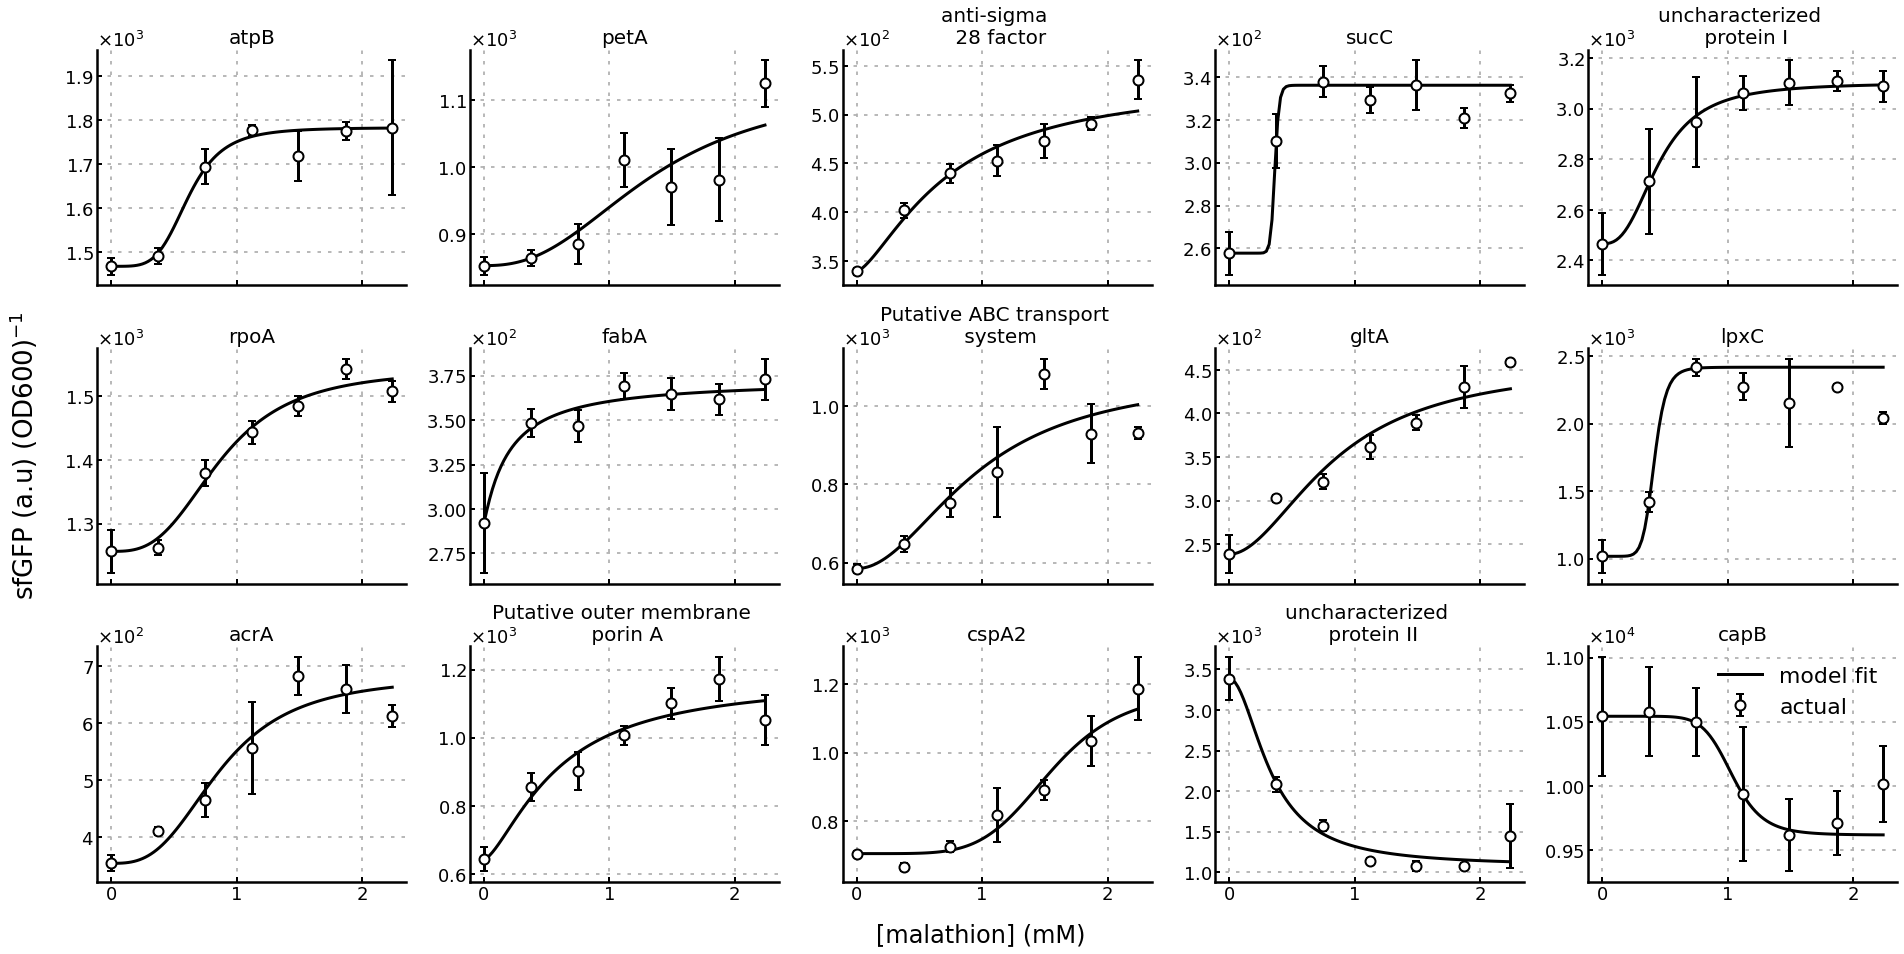

In [10]:
figDir = '/Users/aqib/Desktop/BCCL/NC_submission/figures/fig4/tf_curves.pdf'
plot_tfcurves(fcargmax_0_dict,0,titr_mean_dict,titr_std_dict,doSave=False,saveDir=figDir)

#### Table 1 (partial) in manuscript

In [11]:
# create a new df (eventually latex table) with information about each strain
# what are the columns going to be: 
# strain name, locus_tag, y_max, y_min, K, n
names = ['atpB','petA','anti-sigma 28 factor','sucC','Uncharacterized protein I','rpoA','fabA',
        'Putative ABC transport protein','gltA','Putative outer membrane porin A protein','acrA','lpxC',
        'cspA2','capB','Uncharacterized protein II']
tags = ['PFLU\_6124','PFLU\_0841','PFLU\_4736','PFLU\_1823','PFLU\_3761','PFLU\_5502','PFLU\_1836','PFLU\_0376',
        'PFLU\_1815','PFLU\_0953','PFLU\_1380','PFLU\_4612','PFLU\_4150','PFLU\_1302A','PFLU\_1358']
act_or_rep = ['Activator']*13 + ['Repressor']*2

ymins,ymaxs,Ks,ns = [], [], [], []
for ii, strain in enumerate(all_strains):
    if act_or_rep[ii] == 'Activator':
        ymin = (titr_mean_dict[strain])[0,fcargmax_0_dict[strain][-1]]
        ymax = np.max((titr_mean_dict[strain])[:,fcargmax_0_dict[strain][-1]])
        ymins.append(int(ymin))
        ymaxs.append(int(ymax))
    else: 
        ymin = np.min((titr_mean_dict[strain])[:,fcargmax_0_dict[strain][-1]])
        ymax = (titr_mean_dict[strain])[0,fcargmax_0_dict[strain][-1]]
        ymins.append(int(ymin))
        ymaxs.append(int(ymax))
    Ks.append(np.round((K_dict[strain])[fcargmax_0_dict[strain][-1]],1))
    ns.append(np.round((n_dict[strain])[fcargmax_0_dict[strain][-1]],1))
    
d={'Malathion reporter':names,'Locus tag':tags,'Act./Rep.':act_or_rep,
   r'$y_{min}$':ymins,r'$y_{max}$':ymaxs,r'$K_M$':Ks,r'$n$':ns}
reporter_table = pd.DataFrame(d)

In [12]:
print(reporter_table.to_latex(index=False, escape=False))

\begin{tabular}{lllrrrr}
\toprule
                     Malathion reporter &   Locus tag & Act./Rep. &  $y_{min}$ &  $y_{max}$ &  $K_M$ &  $n$ \\
\midrule
                                   atpB &  PFLU\_6124 & Activator &       1467 &       1783 &    0.6 &  4.5 \\
                                   petA &  PFLU\_0841 & Activator &        853 &       1125 &    1.4 &  2.4 \\
                   anti-sigma 28 factor &  PFLU\_4736 & Activator &        339 &        535 &    0.7 &  1.5 \\
                                   sucC &  PFLU\_1823 & Activator &        257 &        337 &    0.4 & 21.6 \\
              Uncharacterized protein I &  PFLU\_3761 & Activator &       2465 &       3110 &    0.5 &  2.7 \\
                                   rpoA &  PFLU\_5502 & Activator &       1256 &       1542 &    0.9 &  3.0 \\
                                   fabA &  PFLU\_1836 & Activator &        292 &        373 &    0.2 &  1.1 \\
         Putative ABC transport protein &  PFLU\_0376 & Activator &  

#### Visualize fold change over time as heatmap

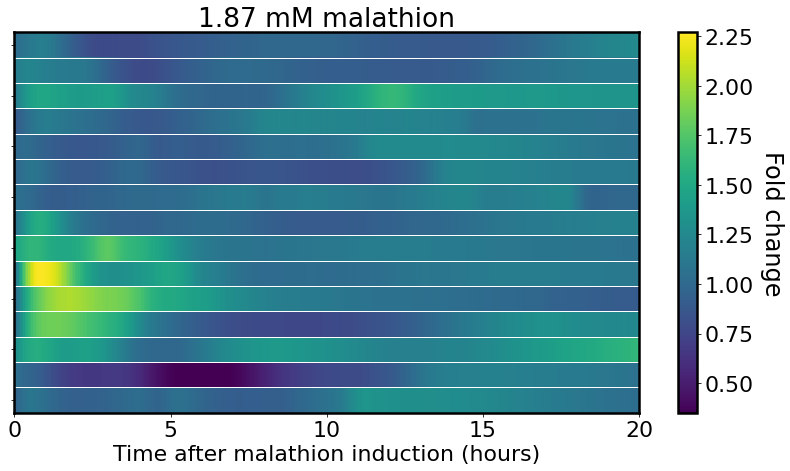

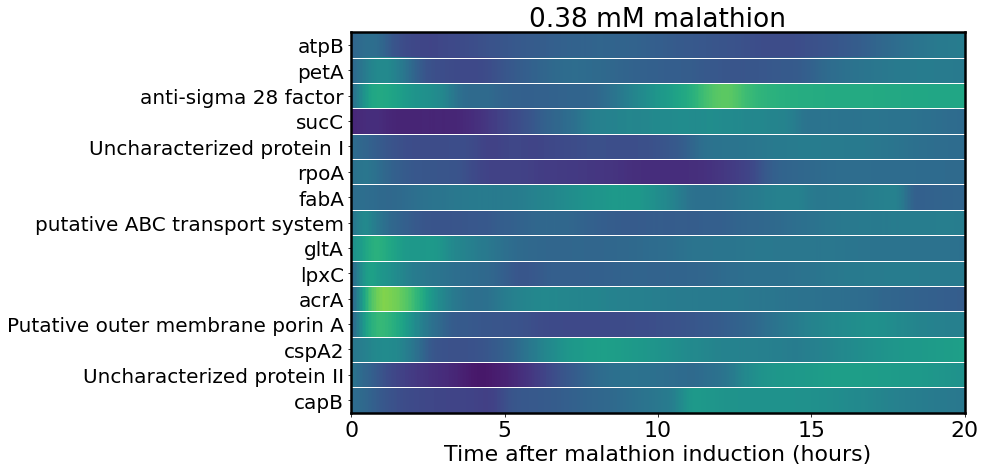

In [13]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/NC_submission/figures/fig4/'
plt.rcParams.update({'font.size':22});
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

this_cond = 5
fc_list = []
for strain in all_strains:
    fc_list.append(titr_fc_dict[strain][this_cond])    
fig1,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_title('1.87 mM malathion')
f = ax.imshow(savgol(np.array(fc_list)[:,0:400],11,1,axis=1),aspect='auto',interpolation='nearest',\
              extent=[0,20,-0.5,14.5],vmin=0.35,vmax=2.27)
# ax.set_yticks(list(range(15)))
ax.set_xticks(list(range(0,25,5)))
cb = plt.colorbar(f)
cb.outline.set_linewidth(2.5)
cbylab = cb.ax.set_ylabel('Fold change',fontsize=24,rotation=270,labelpad=30)
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.set_xlabel('Time after malathion induction (hours)',fontsize=22)
ax.set_yticklabels([],fontsize=20)
ax.hlines([ii + 0.5 for ii in list(range(15)) ],0,20,color='white',lw=1)

this_cond = 1
fc_list = []
for strain in all_strains:
    fc_list.append(titr_fc_dict[strain][this_cond])    
fig2,ax = plt.subplots(1,1,figsize=(11,7))
ax.set_title('0.38 mM malathion')
f = ax.imshow(savgol(np.array(fc_list)[:,0:400],11,1,axis=1),aspect='auto',interpolation='nearest',\
              extent=[0,20,-0.5,14.5],vmin=0.35,vmax=2.27)
ax.set_yticks(list(range(15)))
ax.set_xticks(list(range(0,25,5)))
# cb = plt.colorbar(f)
# cb.outline.set_linewidth(2.5)
# cbylab = cb.ax.set_ylabel('Fold change for 0.38 mM malathion',fontsize=24,rotation=270,labelpad=30)
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.set_xlabel('Time after malathion induction (hours)',fontsize=22)
ax.set_yticklabels(all_genes[::-1],fontsize=20)
ax.hlines([ii + 0.5 for ii in list(range(15)) ],0,20,color='white',lw=1)

if savefig: 
    fig1.savefig(figDir+'time_series_hmap_high.pdf',dpi=300,bbox_inches='tight',transparent=True)
    fig2.savefig(figDir+'time_series_hmap_low.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

